In [2]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [3]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [4]:
test_x = np.load("/content/drive/MyDrive/test_x.npy")
test_y = np.load("/content/drive/MyDrive/test_y.npy")

In [5]:
print(test_x.shape)
print(test_y.shape)

(509, 128, 128, 3)
(509,)


In [6]:
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW

In [7]:
vgg = tf.keras.models.load_model('drive/MyDrive/vgg19_trained.h5')
eff = tf.keras.models.load_model('drive/MyDrive/Eff_with_sampling.h5')
vit = tf.keras.models.load_model('drive/MyDrive/vit_sampled_78',custom_objects = {'AdamW' : AdamW})
all_models = []
all_models.append(vgg)
all_models.append(eff)
all_models.append(vit)

In [8]:
members = list(reversed(all_models))

In [9]:
def fun(e):
  return 1 if e>0.5 else 0

vfun = np.vectorize(fun)

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	yhats = vfun(yhats)
	print(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result

In [12]:
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return yhat,testy,accuracy_score(testy, yhat)

In [13]:
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	# evaluate model with i members
  yhat,testy,ensemble_score = evaluate_n_members(members, i, test_x, test_y)
  single_score = members[i-1].evaluate(test_x, test_y, verbose=0)
  single_score = single_score[1]
  print(single_score)
  print(ensemble_score)
  #summarize this step
  print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
  ensemble_scores.append(ensemble_score)
  single_scores.append(single_score)

[[[1 0 0]
  [1 1 0]
  [0 1 0]
  ...
  [0 1 0]
  [0 1 0]
  [1 0 0]]]
0.7858546376228333
0.7190569744597249
> 1: single=0.786, ensemble=0.719
[[[1 0 0]
  [1 1 0]
  [0 1 0]
  ...
  [0 1 0]
  [0 1 0]
  [1 0 0]]

 [[0 0 1]
  [1 0 0]
  [0 0 1]
  ...
  [0 0 1]
  [1 0 0]
  [1 0 0]]]
0.664047122001648
0.7092337917485265
> 2: single=0.664, ensemble=0.709
[[[1 0 0]
  [1 1 0]
  [0 1 0]
  ...
  [0 1 0]
  [0 1 0]
  [1 0 0]]

 [[0 0 1]
  [1 0 0]
  [0 0 1]
  ...
  [0 0 1]
  [1 0 0]
  [1 0 0]]

 [[0 0 1]
  [0 1 0]
  [0 1 0]
  ...
  [0 1 0]
  [0 1 0]
  [1 0 0]]]
0.8722985982894897
0.8388998035363457
> 3: single=0.872, ensemble=0.839


In [14]:
print('Accuracy %.3f (%.3f)' % (np.mean(single_scores), np.std(single_scores)))

Accuracy 0.774 (0.085)


In [15]:
print('Accuracy %.3f (%.3f)' % (np.mean(ensemble_scores), np.std(ensemble_scores)))

Accuracy 0.756 (0.059)


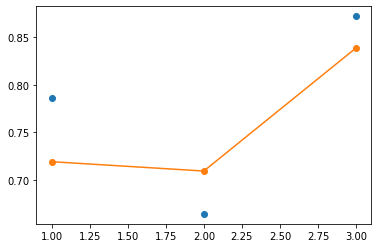

In [16]:
x_axis = [i for i in range(1, len(members)+1)]
plt.plot(x_axis, single_scores, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_scores, marker='o')
plt.show()

In [17]:
from sklearn.metrics import f1_score
f1_score(yhat,testy,average='weighted')

0.8415632214185627

In [18]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score
import numpy as np
print(classification_report(yhat,testy))
print(confusion_matrix(yhat,testy))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79       216
           1       0.97      0.98      0.98       178
           2       0.62      0.87      0.72       115

    accuracy                           0.84       509
   macro avg       0.83      0.85      0.83       509
weighted avg       0.86      0.84      0.84       509

[[152   5  59]
 [  1 175   2]
 [ 15   0 100]]


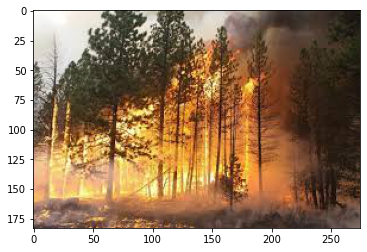

In [22]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from keras.preprocessing import image
import cv2 as cv
images = ['00bf1649-7f48-44ce-b208-a648023bd65a.jpg']
X = []
for img_path in images:
  img = cv.imread(img_path)
  img = cv.resize(img,(128,128))
  #img = cv.Canny(img,100,200)
  img = preprocess_input(img)
  x = np.array(img)
  x=x/255.0
  x = np.expand_dims(x,axis = 0)
  X.append(x)
  my_image = imread(img_path)
  plt.figure()
  imshow(my_image)

In [23]:
labeling = ['Negative','Neutral','Positive']
for i in range (1):
  pred = ensemble_predictions(members,X[i])
  print(pred)
  print(labeling[np.argmax(pred)])

[[[1 0 1]]

 [[1 0 0]]

 [[1 0 0]]]
[0]
Negative
